## Amazon Book Review
This repository contains the basic process notebook for Group 42's project, which analyzes the tendency of users to overrate items.

Due to the computational requirements of processing the full 500,000-review dataset, this notebook provides a representative demonstration using a 100-sample subset. The processes outlined here reflect the methodology applied to the entire dataset. Important Note: Because this notebook uses only the subset, all resulting plots, summary statistics, and model output do not reflect the final figures used in the official report; they serve purely as an illustration of the process. Following steps are contained.


0. Data loading
1. Preprocessing
1.1 Preprocessing Minhashing

2. Create Embeddings
2.1 Minhashing
2.2 SBert

3. Clustering for Minhashing
3.1 K-Means
3.2 HDBscan with UMAP

4. Clustering with SBert
4.1 Preprocessing for Cluster
4.2 K-Means
4.3 HDBSCAN

5. Analysis




#### 0. Data loading

In [ ]:
# load dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import html
import collections
from collections import Counter

import os
import sys
import argparse
import logging
from datetime import datetime

import numpy as np
import pandas as pd


import pyarrow as pa
import pyarrow.parquet as pq
from sentence_transformers import SentenceTransformer

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

import fasttext
from tqdm import tqdm

import numpy as np
#import pyarrow as pa
#import pyarrow.parquet as pq

from pathlib import Path
import glob

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, DBSCAN
import hdbscan
from sklearn.metrics import davies_bouldin_score
import pandas as pd
import matplotlib.pyplot as plt
import umap

from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap

import mmh3



import nltk
from nltk.corpus import stopwords

ModuleNotFoundError: No module named 'pyarrow'

In [4]:
# load data
path_book_reviews = "100_reviews.csv" #### SET THE PATH
br = pd.read_csv(path_book_reviews)


In [5]:
print(len(br))

100


#### 1. Preprocessing

##### 1.1 Preprocessing 

In [6]:
#filter columns
br = br[['Id','review/score', 'review/text']]
#drop NA values
br = br.dropna(subset=['review/text', 'review/score'])
#unescape html characters
br['cleanText'] = br['review/text'].astype(str).apply(html.unescape)

In [7]:
# --- Combined cleaning function ---
def clean_text_all(text):
    text = str(text)

    # 1. Remove control characters (non-printable ASCII)
    # \x00-\x1F are control chars, \x7F is DEL
    text = re.sub(r'[\x00-\x1F\x7F]', '', text)

    # 2. Remove URLs (http/https/www)
    text = re.sub(r'http\S+|www\S+', '', text)

    # 3. Replace newlines, carriage returns, tabs with a single space
    text = re.sub(r'[\r\n\t]+', ' ', text)

    # 4. Normalize multiple spaces to one and strip leading/trailing spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# --- Apply to your dataframe ---
br['cleanText'] = br['cleanText'].apply(clean_text_all)

In [8]:
# Remove rows where 'cleanText' is empty after cleaning
br = br.dropna(subset=['cleanText'])

In [9]:
# Drop all rows that contain non-ASCII characters
# Create a boolean mask for rows that contain any non-ASCII characters
mask_non_ascii = br['cleanText'].str.contains(r'[^\x00-\x7F]', regex=True)

# Print how many will be dropped
print(f"Rows containing non-ASCII characters: {mask_non_ascii.sum()}")

# Drop those rows
br_clean = br[~mask_non_ascii].copy()

Rows containing non-ASCII characters: 1


In [10]:
# replace \' with ' and \" with " "
br_clean['cleanText'] = br_clean['cleanText'].str.replace(r"\\'", "'", regex=True)
br_clean['cleanText'] = br_clean['cleanText'].str.replace(r'\\"', '"', regex=True)

In [11]:
br_clean[['Id', 'review/score', 'cleanText']].to_csv('Books_rating_preprocessed.csv', index=False)

In [12]:
print(br_clean.head())
print(br_clean.shape)

           Id  review/score  \
0  B0006CR6U4           4.0   
1  0897166159           2.0   
2  0736693408           5.0   
3  0395051029           4.0   
4  4770016050           5.0   

                                         review/text  \
0  Jastrow made a great workthis dictionary can h...   
1  Extremely disappointed by the SHORT length and...   
2  This, like all of Brook's Shannara series book...   
3  I enjoyed this classic. I didn't know the stor...   
4  I would love to read this book. Have accepted ...   

                                           cleanText  
0  Jastrow made a great workthis dictionary can h...  
1  Extremely disappointed by the SHORT length and...  
2  This, like all of Brook's Shannara series book...  
3  I enjoyed this classic. I didn't know the stor...  
4  I would love to read this book. Have accepted ...  
(99, 4)


In [ ]:
#filtering english reviews only
ft_model = fasttext.load_model('data/lid.176.ftz')
total = en_count = unknown_count = 0
header_written = False

ModuleNotFoundError: No module named 'fasttext'

In [18]:
def safe_predict(ft_model, texts, k=1):
    """predict languages with error handling - only use highest prob label"""
    try:
        labels, _ = ft_model.predict(texts, k=k)
        langs = []
        for lab in labels:
            if not lab:
                langs.append("unknown")
            else:
                langs.append(lab[0].replace("__label__", ""))
        return langs
    except Exception:
        return ["unknown"] * len(texts)

In [14]:
texts = br_clean["review/text"].fillna("").astype(str)

short_mask = texts.str.split().map(len) < 1
langs = safe_predict(ft_model, texts.tolist(), k=1)
br_clean["lang"] = langs
br_clean.loc[short_mask, "lang"] = "unknown"

en_mask = br_clean["lang"].eq("en")
unk_mask = br_clean["lang"].eq("unknown")

en_count = int(en_mask.sum())
unknown_count = int(unk_mask.sum())

en_chunk = br_clean[en_mask]

en_chunk.to_csv("100_reviews_en.csv", index=False)
br_clean_en = br_clean[en_mask]

NameError: name 'ft_model' is not defined

In [15]:
print(br_clean_en.head())
print(br_clean_en.shape)

           Id  review/score  \
0  B0006CR6U4           4.0   
1  0897166159           2.0   
2  0736693408           5.0   
3  0395051029           4.0   
4  4770016050           5.0   

                                         review/text  \
0  Jastrow made a great workthis dictionary can h...   
1  Extremely disappointed by the SHORT length and...   
2  This, like all of Brook's Shannara series book...   
3  I enjoyed this classic. I didn't know the stor...   
4  I would love to read this book. Have accepted ...   

                                           cleanText lang  
0  Jastrow made a great workthis dictionary can h...   en  
1  Extremely disappointed by the SHORT length and...   en  
2  This, like all of Brook's Shannara series book...   en  
3  I enjoyed this classic. I didn't know the stor...   en  
4  I would love to read this book. Have accepted ...   en  
(98, 5)


##### 1.2 Preprocessing Minhashing

In [ ]:
#additional preprocess to the clean dataset
br_minhashing=br_clean_en

In [23]:
#remove punctuation
br_minhashing['cleanText']=br_minhashing['cleanText'].str.replace(r'[^\w\s]', '', regex=True)
print(br_minhashing['cleanText'].sample(1).iloc[0])

#remove numbers
br_minhashing['cleanText'] = br_minhashing['cleanText'].str.replace(r'\d+', '', regex=True)
print(br_minhashing['cleanText'].sample(1).iloc[0])

#remove stopwords
stop_words = set(stopwords.words('english'))
br_minhashing['cleanText'] = br_minhashing['cleanText'].apply(
    lambda x: ' '.join([word for word in str(x).split() if word not in stop_words])
)
print(br_minhashing['cleanText'].sample(1).iloc[0])


#remove extra white-space 
br_minhashing['cleanText'] = br_minhashing['cleanText'].str.replace(r'\s+', ' ', regex=True).str.strip()
print(br_minhashing['cleanText'].sample(1).iloc[0])

#convert to lowercase
br_minhashing['cleanText'] = br_minhashing['cleanText'].str.lower()
print(br_minhashing['cleanText'].sample(1).iloc[0])

Though I had to read each chapter over and over for the message to sink in I found it to be a great book with many lessons The most difficult for most is to make decisions that arent based from ones ego Its very thought provoking and well worth the necessary studying to achieve a better understanding
While this book was not bad it just did not measure up to the first book of Landviks which I read Patty Janes House of Curl I loved that book but merely liked this latest one I found parts of it to be verrrrrrry slow and just wanted to get to the end It took me  days to read it which to me says this is not a book that was compellingThe synopsis has already been written several times so I will not go into thatsuffice it to say that the story was just okay in my opinion I liked Violet and the boys but they were not nearly as fleshedout as Patty Jane and her family and friendsI also felt that after dragging out the story of the first couple of years the book story was concluded too rapidly


LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/Users/sararedaelli/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.13/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.13/share/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.13/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [24]:
print(br_minhashing.head())
print(br_minhashing.shape)

           Id  review/score  \
0  B0006CR6U4           4.0   
1  0897166159           2.0   
2  0736693408           5.0   
3  0395051029           4.0   
4  4770016050           5.0   

                                         review/text  \
0  Jastrow made a great workthis dictionary can h...   
1  Extremely disappointed by the SHORT length and...   
2  This, like all of Brook's Shannara series book...   
3  I enjoyed this classic. I didn't know the stor...   
4  I would love to read this book. Have accepted ...   

                                           cleanText  
0  Jastrow made a great workthis dictionary can h...  
1  Extremely disappointed by the SHORT length and...  
2  This like all of Brooks Shannara series books ...  
3  I enjoyed this classic I didnt know the story ...  
4  I would love to read this book Have accepted s...  
(99, 4)


#### 2. Create Embeddings

##### 2.1 Embeddings Minhasing 

In [25]:
def Get_word_shingles(text, q=1):
    """Return q-word shingles from pre-cleaned text using simple split."""
    #Ensure the text is always a string
    if not isinstance(text, str):
        text = "" if pd.isna(text) else str(text)
    
    #split the text in words
    words = text.split()
    
    #if text has less than q words return all text in 1 shingle
    if len(words) < q:
        return [" ".join(words)]  # single shingle if too short
    
    #create shingles of q words
    return [" ".join(words[i:i+q]) for i in range(len(words) - q + 1)]

def base_hash(shingle):
    """Convert a shingle in number applying a basic hash function (MurmurHash3 from package mmh3.hash) """
    return np.uint32(mmh3.hash(shingle, signed=False))

def Minhash_signature(shingles,num_hashes,hash_space):
    """Return Minhash siganture for a set of shingles"""
    
    #Uses base_hash function to convert the vector of shingles in numbers
    hash_values_shingles = np.array([base_hash(s) for s in shingles], dtype=np.uint64)
    
    #define a new set of hash functions for Minhashing 
    #hash function: h_i(x) = (a_i * x + b_i) mod max_hash
    np.random.seed(42)  #set seed to ensure reproducibility
    a = np.random.randint(1, hash_space, size=num_hashes, dtype=np.uint64)
    b = np.random.randint(0, hash_space, size=num_hashes, dtype=np.uint64)

    #create a vector to store the signature 
    signature = np.full(num_hashes, np.inf)
    
    for i in range(num_hashes):
        #apply each hash functions h_i to the hash_values (set of shingles converted in numbers)
        h_i_values = (a[i] * hash_values_shingles + b[i]) % hash_space
        #for each hash function take the minimum between the h_i_values
        signature[i]=h_i_values.min()

    return signature.astype(np.uint32)

In [26]:
def Minhashing(reviews,q, num_hashes, hash_space):
    """
    Returns MinHash signatures for a dataset of text reviews.

    This function converts each review into a set of q-grams (substrings of length q),
    then applies multiple hash functions to create MinHash signatures.

    Args:
        reviews (list[str]): A list of text strings (reviews) to process.
        q (int): The number of words of each  shingle used to tokenize the reviews.
        num_hashes (int): The number of hash functions (signature vector size).
        hash_space (int): The size of the hash value space.

    Returns:
        list[list[int]]: A list where each element is the MinHash signature
        (a list of integers) corresponding to one review.
    """
    
    #Create empty lists to store signatures for all the reviews
    signatures = []

    #Create signature for each review
    for review in reviews:    
        
        #get a vector of shingles from the review
        shingles = Get_word_shingles(review, q=q)
        #get the signature vector using Minhashing
        signature = Minhash_signature(shingles,num_hashes,hash_space)
    
        
        signatures.append(signature)
    
    return signatures

In [27]:
#Minhashing embeddings

#choice of parameters 
q=1 #number of words of each shingle used to tokenize the reviews
num_hashes=100 #number of hash functions (signature vector size)
hash_space= 2**32-1 #size of the hash value space

#get Minhash signatures vector form the text reviews
signatures=Minhashing(br_minhashing['cleanText'],q,num_hashes,hash_space)


#add the embeddings to the dataset 
br_minhashing["Signature"] = list(signatures)

In [28]:
print(br_minhashing.head())
print(br_minhashing.shape)

           Id  review/score  \
0  B0006CR6U4           4.0   
1  0897166159           2.0   
2  0736693408           5.0   
3  0395051029           4.0   
4  4770016050           5.0   

                                         review/text  \
0  Jastrow made a great workthis dictionary can h...   
1  Extremely disappointed by the SHORT length and...   
2  This, like all of Brook's Shannara series book...   
3  I enjoyed this classic. I didn't know the stor...   
4  I would love to read this book. Have accepted ...   

                                           cleanText  \
0  Jastrow made a great workthis dictionary can h...   
1  Extremely disappointed by the SHORT length and...   
2  This like all of Brooks Shannara series books ...   
3  I enjoyed this classic I didnt know the story ...   
4  I would love to read this book Have accepted s...   

                                           Signature  
0  [72671894, 25011381, 2530687, 8329230, 3847776...  
1  [42747999, 101365923, 2410

##### 2.2 Embeddings SBert 

In [24]:
def as_arrow_table(ids, texts, score, embs, sent_scores):
    arr_ids = pa.array(ids)
    arr_texts = pa.array(texts, type=pa.string())
    arr_scores = pa.array(score)
    list_of_lists = [emb.tolist() for emb in embs]
    arr_embs = pa.array(list_of_lists, type=pa.list_(pa.float32()))
    
    arr_sent = pa.array(sent_scores.tolist(), type=pa.float32())
    return pa.Table.from_arrays(
        [arr_ids, arr_scores, arr_texts, arr_embs, arr_sent],
        names=["row_id", "review/score", "cleanText", "embedding", "sentiment_score"]

    )

In [25]:
def compute_sentiment_scores(texts, tokenizer, model, device, batch_size=64, max_length=256):

    scores = []
    model.eval()

    with torch.no_grad():
        for start in range(0, len(texts), batch_size):
            batch_texts = texts[start:start + batch_size]
            enc = tokenizer(
                batch_texts,
                return_tensors="pt",
                truncation=True,
                padding=True,
                max_length=max_length
            )
            enc = {k: v.to(device) for k, v in enc.items()}

            outputs = model(**enc)
            probs = F.softmax(outputs.logits, dim=1)  # shape: [B, 5] (for 1–5 stars)

            stars = torch.arange(1, probs.size(1) + 1, device=device, dtype=torch.float32)
            batch_scores = (probs * stars).sum(dim=1) 
            scores.extend(batch_scores.cpu().numpy().tolist())

    return np.array(scores, dtype=np.float32)

In [26]:
# Create SBERT and Sentiment Analysis models
model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

sent_tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment" )
sent_model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

In [27]:
# get texts and scores
texts = br_clean_en["cleanText"].astype(str).tolist()
score = br_clean_en["Id"].astype(str).tolist()

In [28]:
embs = model.encode(
                texts,
                convert_to_numpy=True,
                show_progress_bar=True
            ).astype(np.float32)


Batches: 100%|██████████| 4/4 [00:26<00:00,  6.51s/it]


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sentiment_scores = compute_sentiment_scores(
                texts,
                sent_tokenizer,
                sent_model,
                device=device,
                batch_size=64,       
                max_length=256
            )

In [30]:
# add embeddings and sentiment scores and data to arrow table
embeddings = as_arrow_table(
    ids=br_clean_en["Id"].astype(str).tolist(),
    texts=br_clean_en["cleanText"].astype(str).tolist(),
    score=br_clean_en["review/score"].astype(str).tolist(),
    embs=embs,
    sent_scores=sentiment_scores
)
pq.write_table(embeddings, "book_reviews_with_embeddings_and_sentiment.parquet")



In [31]:
#show embeddings header
print((pa.parquet.read_table("book_reviews_with_embeddings_and_sentiment.parquet").to_pandas().head()))


       row_id review/score                                          cleanText  \
0  B0006CR6U4          4.0  jastrow made a great workthis dictionary can h...   
1  0897166159          2.0  extremely disappointed by the short length and...   
2  0736693408          5.0  this like all of brooks shannara series books ...   
3  0395051029          4.0  i enjoyed this classic i didnt know the story ...   
4  4770016050          5.0  i would love to read this book have accepted s...   

                                           embedding  sentiment_score  
0  [-0.056456804, 0.22839126, -0.21344286, -0.088...         3.857612  
1  [-0.043272056, -0.10097221, -0.1669807, -0.112...         1.426598  
2  [0.030179722, -0.23032333, -0.2505245, 0.04533...         4.334844  
3  [0.10693196, 0.17507689, -0.42689034, 0.173017...         4.223716  
4  [0.05158386, -0.18795952, -0.14720729, -0.0180...         1.781276  


#### Clustering for Minhashing 

In [29]:
#Prepare data for clustering:
#Convert integer to float
br_minhashing['Signature'] = br_minhashing['Signature'].apply(
    lambda s: np.array(re.findall(r'-?\d+', str(s)), dtype=int)
)

#Transform the column 'signature' in lists of length 100
X = np.array(br_minhashing['Signature'].tolist())
#Save the true ratings
y = br_minhashing['review/score'].values 

#check X and y shape 
print(X.shape)
print(y.shape)

(99, 100)
(99,)


##### Clustering using Kmeans

In [32]:
#RUN K-MEANS
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
Kmeans_clusters = kmeans.fit_predict(X)

#check clustering results 
Kmeans_clusters.shape
print(Kmeans_clusters[70:75])
print(np.unique(Kmeans_clusters))

[0 0 3 0 0]
[0 1 2 3 4]


##### Evaluation

In [33]:
clusters=Kmeans_clusters+1  # shift to make clusters start at 1

In [ ]:
#EVALUATION using DAVIES-BOULDIN INDEX
def DB(X, clusters):
    unique_labels = np.unique(clusters)

    # If there is only 1 cluster DB cannot be computed
    if len(unique_labels) < 2:
        print("Davies–Bouldin cannot be computed: only one cluster is present.")
        return None

    return davies_bouldin_score(X, clusters)

#Evaluate K-Means
db_Kmeans = DB(X, Kmeans_clusters)
print(f"Davies-Bouldin Index (DB): {db_Kmeans:.4f}")

Davies-Bouldin Index (DB): 1.4828


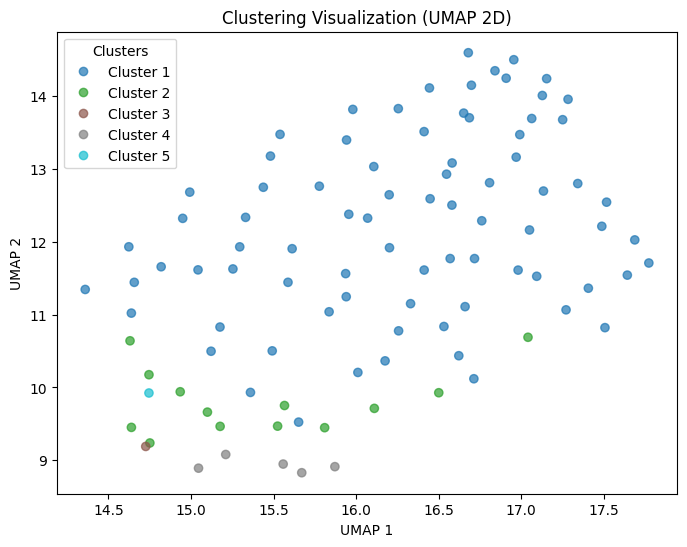

In [35]:
#VISUALIZATION of CLUSTERS
# Reduce to 2D using UMAP
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1)
X2_umap = umap_model.fit_transform(X)
plt.figure(figsize=(8,6))
scatter = plt.scatter(X2_umap[:, 0], X2_umap[:, 1],
                      c=clusters, cmap='tab10', alpha=0.7)

# Legend for cluster IDs
handles, labels = scatter.legend_elements()
plt.legend(handles, [f"Cluster {i}" for i in np.unique(clusters)], 
           title="Clusters")

plt.title("Clustering Visualization (UMAP 2D)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

rating   1.0  2.0  3.0  4.0  5.0
cluster                         
1          7    0    5   20   47
2          1    0    1    3    8
3          0    0    0    1    0
4          0    2    0    0    3
5          0    0    0    0    1


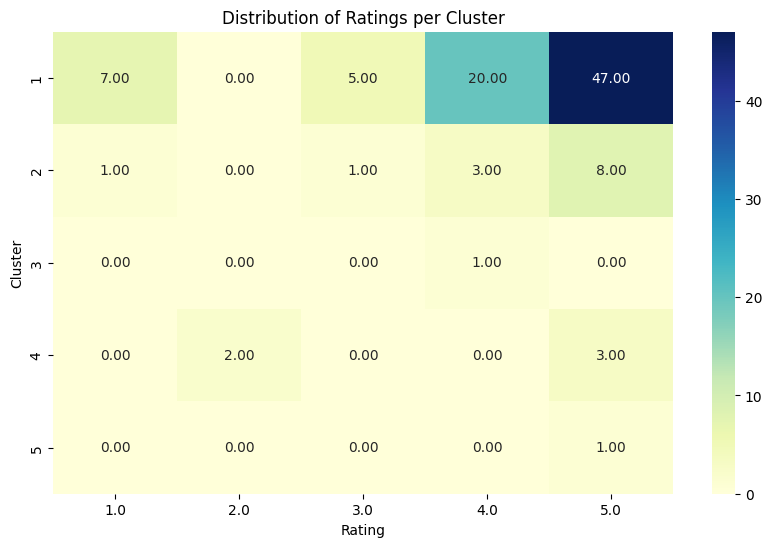

rating     1.0  2.0       3.0       4.0       5.0
cluster                                          
1        0.875  0.0  0.833333  0.833333  0.796610
2        0.125  0.0  0.166667  0.125000  0.135593
3        0.000  0.0  0.000000  0.041667  0.000000
4        0.000  1.0  0.000000  0.000000  0.050847
5        0.000  0.0  0.000000  0.000000  0.016949


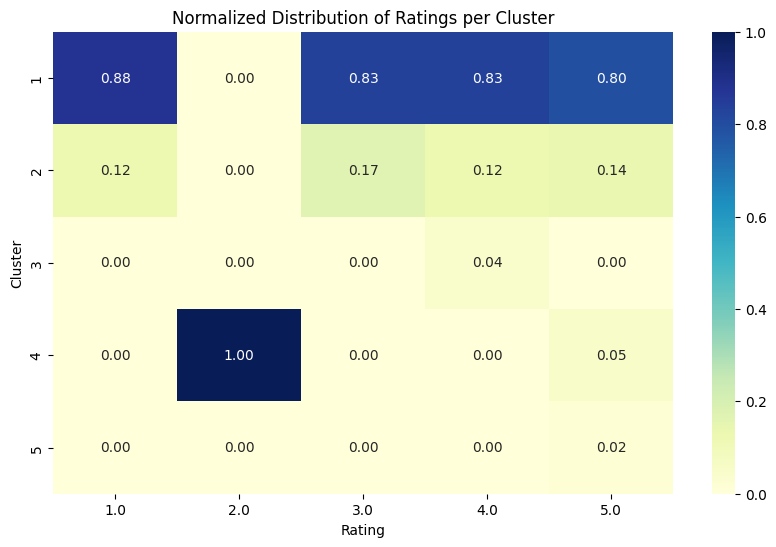

In [37]:
#ANALYSIS OF CLUSTERS WITH RESPECT TO RATINGS

# Create dataframe containing ratings and cluster assignments
df_results = pd.DataFrame({
    'rating': y,
    'cluster': clusters
})

#Table showing distribution of ratings per cluster
cluster_summary = pd.crosstab(df_results['cluster'], df_results['rating'])
print(cluster_summary)

#print heatmap 
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(cluster_summary, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Distribution of Ratings per Cluster")
plt.xlabel("Rating")
plt.ylabel("Cluster")
plt.show()

#Normalize the values to take into account the size of each group of rating 
for i in range(1,6):
    cluster_summary[i] = cluster_summary[i] / cluster_summary[i].sum()
print(cluster_summary)

#print heatmap 
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(cluster_summary, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Normalized Distribution of Ratings per Cluster")
plt.xlabel("Rating")
plt.ylabel("Cluster")
plt.show()


##### Clustering using Hdbscan

In [38]:
#Preprocess for HDBSCAN clustering 
umap_model = umap.UMAP(
    n_neighbors=30,      # controls local vs global structure
    min_dist=0.0,        # tighter clusters
    n_components=15,      
    metric='euclidean',
    random_state=42
)

X_umap = umap_model.fit_transform(X)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
#Run HDBSCAN
HDBSCAN = hdbscan.HDBSCAN(
    min_cluster_size=500,
    min_samples=10
)
Hdbscan_clusters = HDBSCAN.fit_predict(X_umap)

#check clustering results 
Hdbscan_clusters.shape
print(Hdbscan_clusters[70:75])
print(np.unique(Hdbscan_clusters))

[-1 -1 -1 -1 -1]
[-1]


##### Evaluation

In [40]:
clusters=Hdbscan_clusters+1 

In [47]:
#EVALUATION using DAVIES-BOULDIN INDEX
def DB(X, clusters):
    unique_labels = np.unique(clusters)

    # If there is only 1 cluster DB cannot be computed
    if len(unique_labels) < 2:
        print("Davies–Bouldin cannot be computed: only one cluster is present.")
        return None

    return davies_bouldin_score(X, clusters)


db_HDBscan = DB(X, Hdbscan_clusters)

if db_HDBscan is not None:
    print(f"Davies-Bouldin Index (DB) for HDBSCAN: {db_HDBscan:.4f}")
else:
    print("Davies-Bouldin Index (DB) for HDBSCAN: not available (only one cluster).")


Davies–Bouldin cannot be computed: only one cluster is present.
Davies-Bouldin Index (DB) for HDBSCAN: not available (only one cluster).


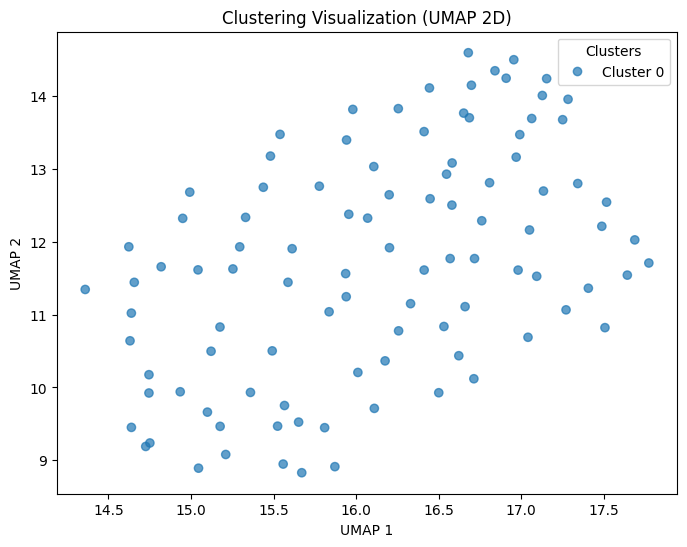

In [43]:
#VISUALIZATION of CLUSTERS
# Reduce to 2D using UMAP
plt.figure(figsize=(8,6))
scatter = plt.scatter(X2_umap[:, 0], X2_umap[:, 1],
                      c=clusters, cmap='tab10', alpha=0.7)

# Legend for cluster IDs
handles, labels = scatter.legend_elements()
plt.legend(handles, [f"Cluster {i}" for i in np.unique(clusters)], 
           title="Clusters")

plt.title("Clustering Visualization (UMAP 2D)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

rating   1.0  2.0  3.0  4.0  5.0
cluster                         
0          8    2    6   24   59


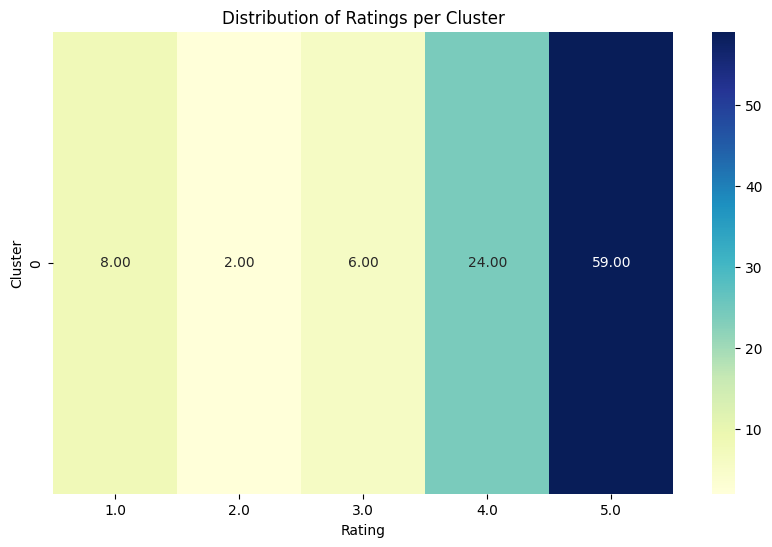

rating   1.0  2.0  3.0  4.0  5.0
cluster                         
0        1.0  1.0  1.0  1.0  1.0


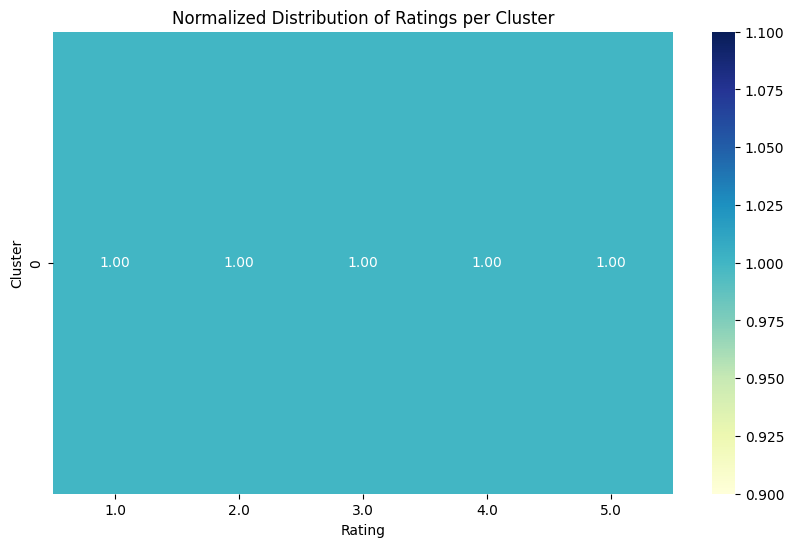

In [44]:
#ANALYSIS OF CLUSTERS WITH RESPECT TO RATINGS
# Create dataframe containing ratings and cluster assignments
df_results = pd.DataFrame({
    'rating': y,
    'cluster': clusters
})

#Table showing distribution of ratings per cluster
cluster_summary = pd.crosstab(df_results['cluster'], df_results['rating'])
print(cluster_summary)

#print heatmap 
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(cluster_summary, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Distribution of Ratings per Cluster")
plt.xlabel("Rating")
plt.ylabel("Cluster")
plt.show()

#Normalize the values to take into account the size of each group of rating 
for i in range(1,6):
    cluster_summary[i] = cluster_summary[i] / cluster_summary[i].sum()
print(cluster_summary)

#print heatmap 
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(cluster_summary, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Normalized Distribution of Ratings per Cluster")
plt.xlabel("Rating")
plt.ylabel("Cluster")
plt.show()

#### Clustering with SBert

##### Preprocessing for clustering (PCA)

In [46]:
def listarray_to_2d_numpy(arr: pa.Array, dtype=np.float32) -> np.ndarray:
    t = arr.type
    if pa.types.is_fixed_size_list(t):
        dim = t.list_size
        flat = arr.values
        out = np.asarray(flat.to_numpy(zero_copy_only=False), dtype=dtype)
        return out.reshape(len(arr), dim)
    elif pa.types.is_list(t):
        py = arr.to_pylist()
        first = next((x for x in py if x is not None), None)
        if first is None:
            return np.empty((len(py), 0), dtype=dtype)
        dim = len(first)
        return np.array(py, dtype=dtype).reshape(len(py), dim)
    else:
        raise TypeError(f"column embeddings must be List/FixedSizeList: {t}")


In [47]:
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(embs).astype(np.float32)

In [48]:
# umap preprocessing for clustering
reducer_15d = umap.UMAP(
        n_neighbors=30,
        min_dist=0.0,
        n_components=15,
        metric="cosine",
        random_state=42,
        init="random",
    )
X_umap15 = reducer_15d.fit_transform(X_pca)

/zhome/3d/c/222266/ComputationalTools/AmazonReview/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [49]:
# replace embeddings with Umap reduced embeddings
embeddings_umap = as_arrow_table(
    ids=br_clean_en["Id"].astype(str).tolist(),
    texts=br_clean_en["cleanText"].astype(str).tolist(),
    score=br_clean_en["review/score"].astype(str).tolist(),
    embs=X_umap15,
    sent_scores=sentiment_scores
)
pq.write_table(embeddings_umap, "book_reviews_with_embeddings_umap_and_sentiment.parquet")

##### Clustering with SBert embeddings

In [71]:
import matplotlib.pyplot as plt
def plot_elbow(X: np.ndarray, k_values):

    db_scores = []

    print("Computing inertia for elbow plot...")
    for k in k_values:
        print(f"  k = {k} ...")

        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        db_index = davies_bouldin_score(X, labels)
        inertia = kmeans.inertia_
        db_scores.append(db_index)
       

    plt.figure(figsize=(8, 5))
    plt.plot(k_values, db_scores, marker="o")
    plt.title("Elbow Plot: KMeans Davies–Bouldin Index vs. k")
    plt.xlabel("k (#clusters)")
    plt.ylabel("Davies–Bouldin Index")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("elbow_kmeans.png", dpi=300)
    plt.show()
    

In [72]:
k_values = [2, 3, 4, 5, 7,9, 10]

Computing inertia for elbow plot...
  k = 2 ...
  k = 3 ...
  k = 4 ...
  k = 5 ...
  k = 7 ...
  k = 9 ...
  k = 10 ...


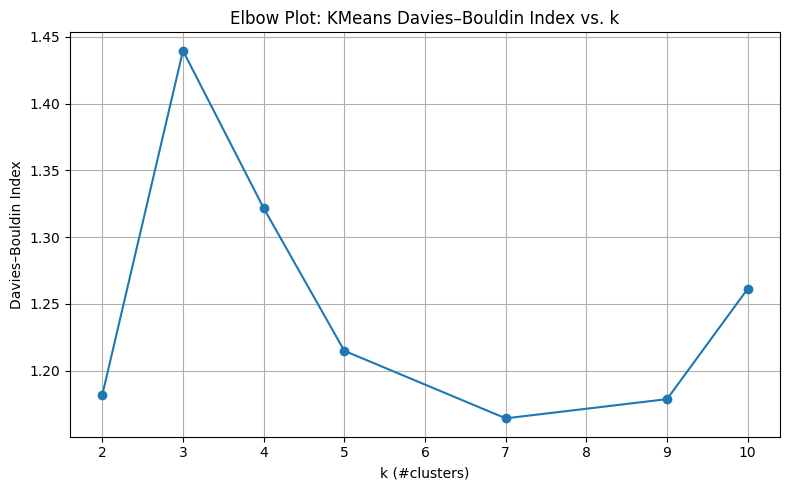

In [73]:
# plot elbow with pca reduced embeddings
plot_elbow(X_umap15, k_values)

In [74]:
kmeans = KMeans(n_clusters=7, n_init="auto", random_state=42)
labels_kmeans = kmeans.fit_predict(X_umap15)

In [75]:
dbi_kmeans = davies_bouldin_score(X_umap15, labels_kmeans)
print(f"Davies–Bouldin Index (KMeans, k={10}): {dbi_kmeans:.4f}")

Davies–Bouldin Index (KMeans, k=10): 1.1642


In [55]:
clusterer = hdbscan.HDBSCAN(
        min_cluster_size=2,
        min_samples=1,
        metric='euclidean'
    )
labels_db = clusterer.fit_predict(X_umap15)

/zhome/3d/c/222266/ComputationalTools/AmazonReview/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/zhome/3d/c/222266/ComputationalTools/AmazonReview/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [56]:

dbHdbscan = davies_bouldin_score(X_umap15, labels_db)
print(dbHdbscan)
       

1.0439855880209974


In [76]:
clustering_results = pd.DataFrame({
    "row_id": br_clean_en["Id"],
    "rating": br_clean_en["review/score"],
    "sentiment_score": sentiment_scores,
    "cluster_kmeans": labels_kmeans,
    "cluster_dbscan": labels_db,
})

In [77]:
print(clustering_results.head())
print(clustering_results.shape)

       row_id  rating  sentiment_score  cluster_kmeans  cluster_dbscan
0  B0006CR6U4     4.0         3.857612               2               9
1  0897166159     2.0         1.426598               3               2
2  0736693408     5.0         4.334844               0              24
3  0395051029     4.0         4.223716               1              25
4  4770016050     5.0         1.781276               4              20
(98, 5)


In [78]:
# save clustering results
clustering_results.to_csv("book_reviews_clustering_results.csv", index=False)

/tmp/ipykernel_147112/4287859085.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_km = plt.cm.get_cmap("tab20", n_km)


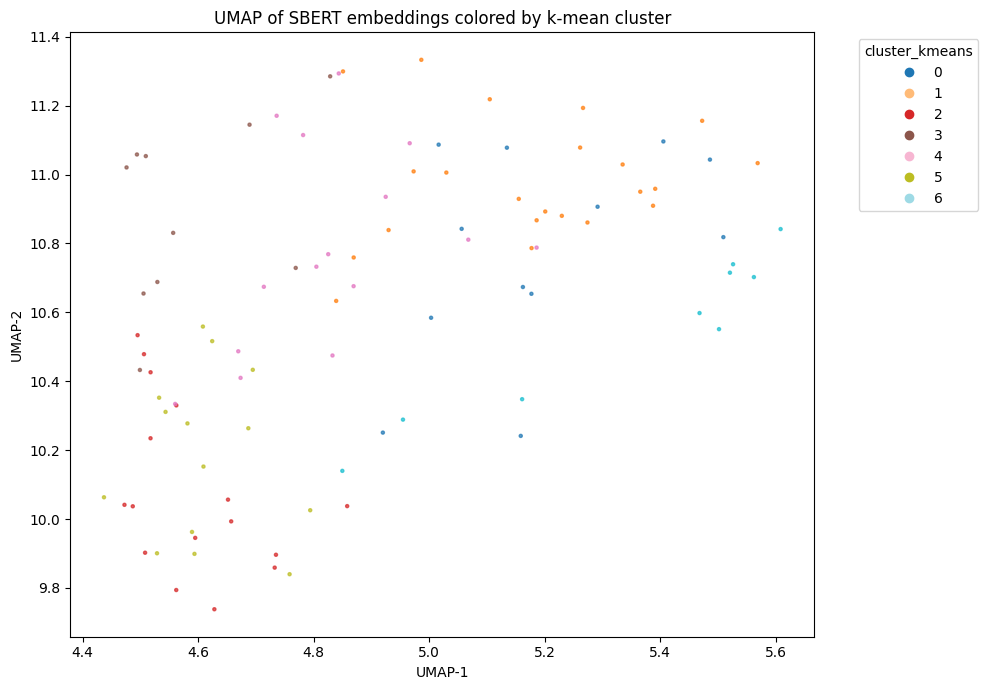

In [80]:
# UMAP for k-means
labels_km = clustering_results["cluster_kmeans"].to_numpy()
unique_km = np.unique(labels_km)
n_km = len(unique_km)

label2idx_km = {lab: i for i, lab in enumerate(unique_km)}
idx_km = np.array([label2idx_km[lab] for lab in labels_km])

cmap_km = plt.cm.get_cmap("tab20", n_km)

plt.figure(figsize=(10, 7))
sc = plt.scatter(
    X_umap15[:, 0],
    X_umap15[:, 1],
    c=labels_kmeans,
    s=5,
    alpha=0.7,
    cmap="tab10"
)
handles = [
        Line2D([0], [0], marker='o', linestyle='',
            color=cmap_km(i), label=str(lab))
        for i, lab in enumerate(unique_km)
    ]
plt.legend(handles=handles, title="cluster_kmeans",
            bbox_to_anchor=(1.05, 1), loc="upper left")


plt.title("UMAP of SBERT embeddings colored by k-mean cluster")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
#out_path = "umap_pca_clusters_kmeans_100.png"
#plt.savefig(out_path, dpi=300)
plt.show()
plt.close()

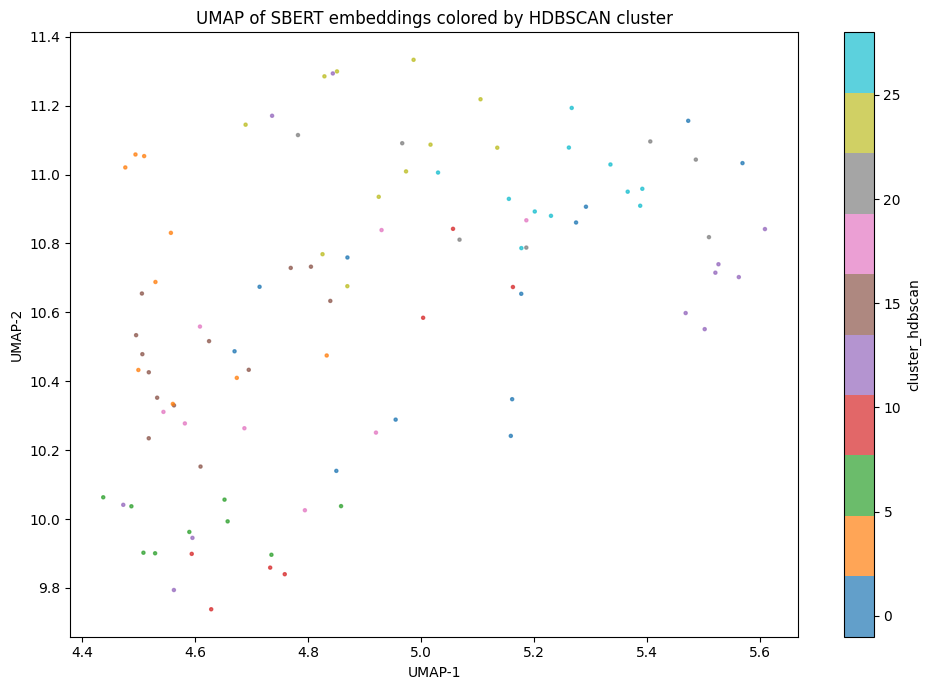

In [81]:
# UMAP for Hdbscan
plt.figure(figsize=(10, 7))
sc = plt.scatter(
    X_umap15[:, 0],
    X_umap15[:, 1],
    c=labels_db,
    s=5,
    alpha=0.7,
    cmap="tab10"
)
plt.colorbar(sc, label="cluster_hdbscan")
plt.title("UMAP of SBERT embeddings colored by HDBSCAN cluster")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
#out_path = "umap_pca_clusters_hdbscan_100.png"
#plt.savefig(out_path, dpi=300)
plt.show()
plt.close()

### Analysis

In [83]:

# Drop noise cluster (-1)
df_clean = clustering_results[clustering_results['cluster_dbscan'] != -1]
df_clean.head()

,row_id,rating,sentiment_score,cluster_kmeans,cluster_dbscan
0,B0006CR6U4,4.0,3.857612,2,9
1,0897166159,2.0,1.426598,3,2
2,0736693408,5.0,4.334844,0,24
3,0395051029,4.0,4.223716,1,25
4,4770016050,5.0,1.781276,4,20


In [84]:
# summarize sentiment scores into categories
# Create a new column with categorized sentiment scores
df_clean['sentiment_category'] = np.clip(df_clean['sentiment_score'].round().astype(int), 1, 5)
df_clean.head(n=100)

/tmp/ipykernel_147112/1436867120.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['sentiment_category'] = np.clip(df_clean['sentiment_score'].round().astype(int), 1, 5)


,row_id,rating,sentiment_score,cluster_kmeans,cluster_dbscan,sentiment_category
0,B0006CR6U4,4.0,3.857612,2,9,4
1,0897166159,2.0,1.426598,3,2,1
2,0736693408,5.0,4.334844,0,24,4
3,0395051029,4.0,4.223716,1,25,4
4,4770016050,5.0,1.781276,4,20,2
...,...,...,...,...,...,...
94,B000F33WU2,4.0,4.382447,5,5,4
95,B00021GLXM,5.0,3.837631,1,27,4
97,B0007JGVHK,5.0,4.177796,5,10,4
98,1404329544,3.0,2.001390,2,9,2


#### Histogram


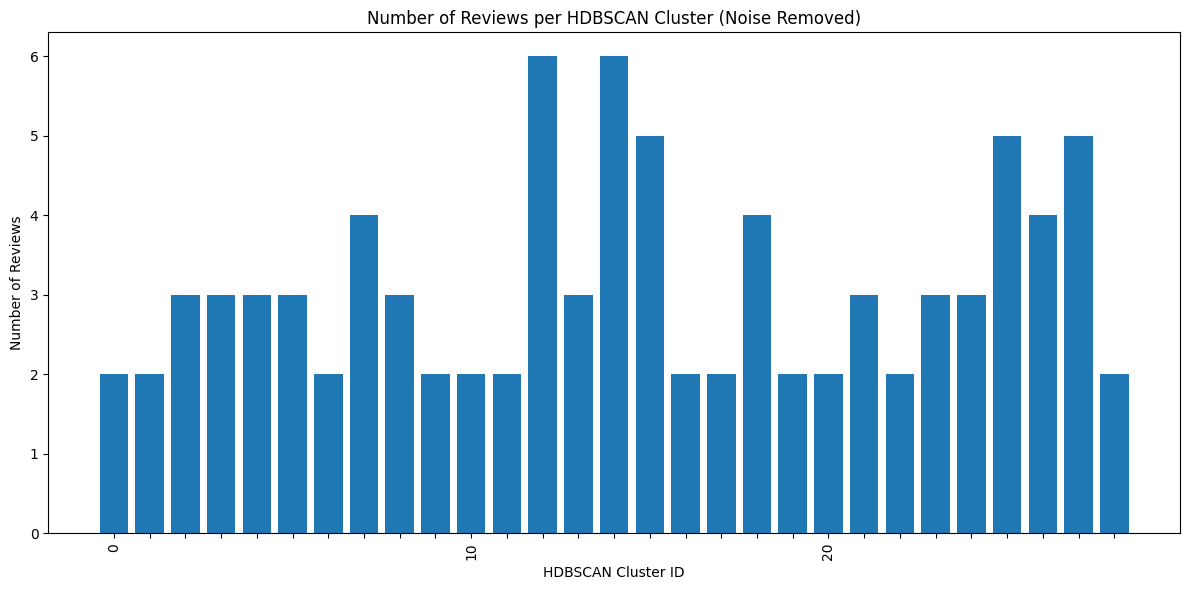

In [85]:
# Count reviews per cluster
cluster_counts = df_clean['cluster_dbscan'].value_counts().sort_index()

plt.figure(figsize=(12,6))
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel('HDBSCAN Cluster ID')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews per HDBSCAN Cluster (Noise Removed)')

# Show only every 10th cluster label
x_labels = [str(c) if i % 10 == 0 else '' for i, c in enumerate(cluster_counts.index)]
plt.xticks(cluster_counts.index, x_labels, rotation=90)

plt.tight_layout()
plt.show()

#### Boxplots

/tmp/ipykernel_147112/2488340801.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=random_clusters)


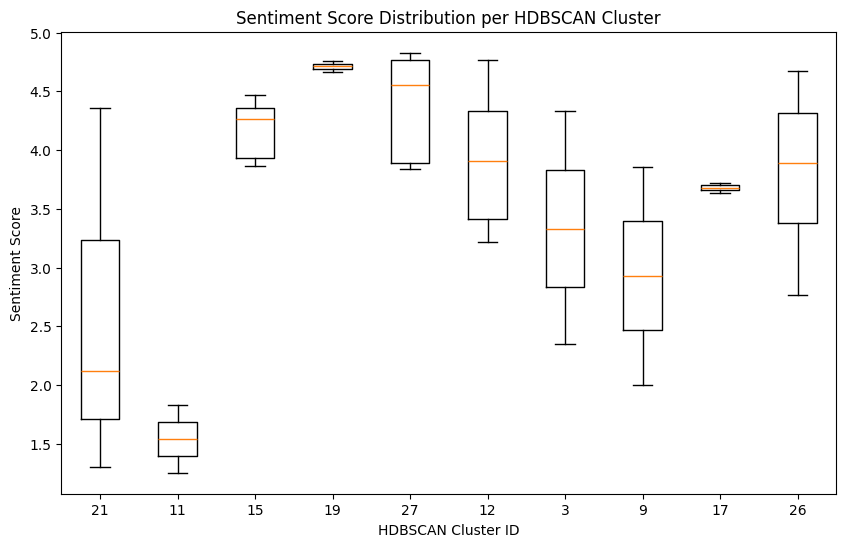

In [86]:
# Get unique cluster IDs
clusters = df_clean['cluster_dbscan'].unique()

# Randomly pick 10 clusters
# set seed for reproducibility
np.random.seed(42)  
random_clusters = np.random.choice(clusters, size=10, replace=False)

# Prepare data for boxplot
boxplot_data = [df_clean[df_clean['cluster_dbscan'] == c]['sentiment_score'] for c in random_clusters]

# Plot
plt.figure(figsize=(10,6))
plt.boxplot(boxplot_data, labels=random_clusters)
plt.xlabel('HDBSCAN Cluster ID')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Score Distribution per HDBSCAN Cluster')
plt.show()

#### Histograms per rating

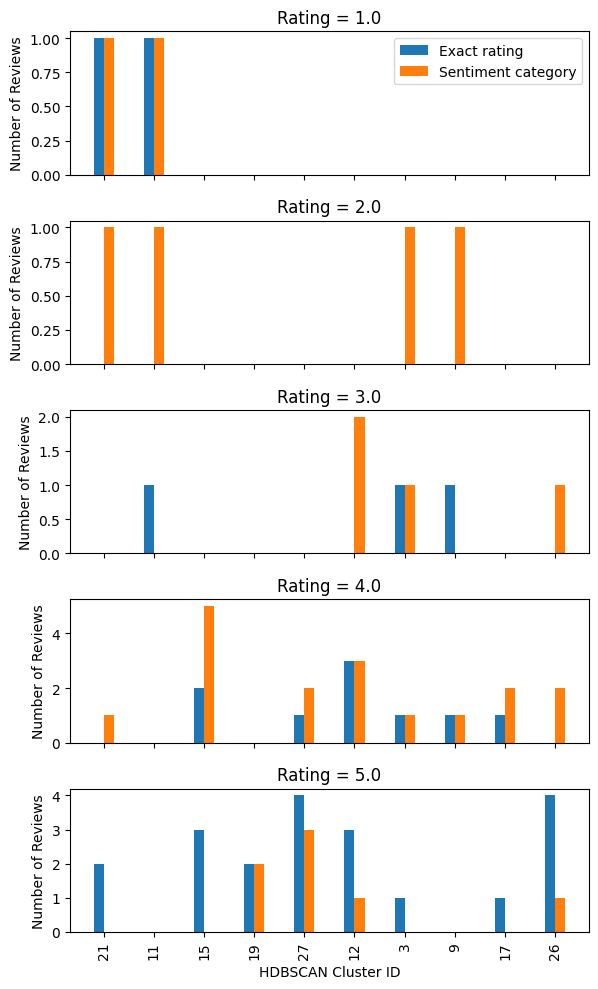

In [87]:

# Use the previously selected subset of clusters 
# Get unique ratings
ratings = sorted(df_clean['rating'].unique())
n_ratings = len(ratings)

fig, axes = plt.subplots(n_ratings, 1, figsize=(6, 2 * n_ratings), sharex=True)

for i, r in enumerate(ratings):
    ax = axes[i] if n_ratings > 1 else axes
    
    count_rating = []
    count_sentiment = []
    
    for cluster in random_clusters:
        cluster_data = df_clean[df_clean['cluster_dbscan'] == cluster]
        count_rating.append((cluster_data['rating'] == r).sum())
        count_sentiment.append((cluster_data['sentiment_category'] == r).sum())
    
    x = np.arange(len(random_clusters))
    width = 0.2
    
    ax.bar(x - width/2, count_rating, width, label='Exact rating')
    ax.bar(x + width/2, count_sentiment, width, label='Sentiment category')
    
    ax.set_ylabel('Number of Reviews')
    ax.set_title(f'Rating = {r}')
    if i == 0:
        ax.legend()

plt.xticks(np.arange(len(random_clusters)), random_clusters, rotation=90)
plt.xlabel('HDBSCAN Cluster ID')
plt.tight_layout()
plt.show()


